In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from matplotlib.lines import Line2D
import matplotlib
import seaborn as sns
import matplotlib.patches as mpatches
import pandas as pd

In [2]:
def enc_list_bl_max_len(aa_seqs, blosum, max_seq_len):
    # encode sequences:
    sequences=[]
    for seq in aa_seqs:
        e_seq=np.zeros((len(seq),len(blosum["A"])))
        count=0
        for aa in seq:
            if aa in blosum:
                e_seq[count]=blosum[aa]
                count+=1
            else:
                print(aa)
                sys.stderr.write("Unknown amino acid in peptides: "+ aa +", encoding aborted!\n")
                sys.exit(2)
                
        sequences.append(e_seq)

    # pad sequences:
    #max_seq_len = max([len(x) for x in aa_seqs])
    n_seqs = len(aa_seqs)
    n_features = sequences[0].shape[1]

    enc_aa_seq = np.zeros((n_seqs, max_seq_len, n_features))
    for i in range(0,n_seqs):
        enc_aa_seq[i, :sequences[i].shape[0], :n_features] = sequences[i]

    return enc_aa_seq


blosum50_20aa = {
        'A': np.array((5,-2,-1,-2,-1,-1,-1,0,-2,-1,-2,-1,-1,-3,-1,1,0,-3,-2,0)),
        'R': np.array((-2,7,-1,-2,-4,1,0,-3,0,-4,-3,3,-2,-3,-3,-1,-1,-3,-1,-3)),
        'N': np.array((-1,-1,7,2,-2,0,0,0,1,-3,-4,0,-2,-4,-2,1,0,-4,-2,-3)),
        'D': np.array((-2,-2,2,8,-4,0,2,-1,-1,-4,-4,-1,-4,-5,-1,0,-1,-5,-3,-4)),
        'C': np.array((-1,-4,-2,-4,13,-3,-3,-3,-3,-2,-2,-3,-2,-2,-4,-1,-1,-5,-3,-1)),
        'Q': np.array((-1,1,0,0,-3,7,2,-2,1,-3,-2,2,0,-4,-1,0,-1,-1,-1,-3)),
        'E': np.array((-1,0,0,2,-3,2,6,-3,0,-4,-3,1,-2,-3,-1,-1,-1,-3,-2,-3)),
        'G': np.array((0,-3,0,-1,-3,-2,-3,8,-2,-4,-4,-2,-3,-4,-2,0,-2,-3,-3,-4)),
        'H': np.array((-2,0,1,-1,-3,1,0,-2,10,-4,-3,0,-1,-1,-2,-1,-2,-3,2,-4)),
        'I': np.array((-1,-4,-3,-4,-2,-3,-4,-4,-4,5,2,-3,2,0,-3,-3,-1,-3,-1,4)),
        'L': np.array((-2,-3,-4,-4,-2,-2,-3,-4,-3,2,5,-3,3,1,-4,-3,-1,-2,-1,1)),
        'K': np.array((-1,3,0,-1,-3,2,1,-2,0,-3,-3,6,-2,-4,-1,0,-1,-3,-2,-3)),
        'M': np.array((-1,-2,-2,-4,-2,0,-2,-3,-1,2,3,-2,7,0,-3,-2,-1,-1,0,1)),
        'F': np.array((-3,-3,-4,-5,-2,-4,-3,-4,-1,0,1,-4,0,8,-4,-3,-2,1,4,-1)),
        'P': np.array((-1,-3,-2,-1,-4,-1,-1,-2,-2,-3,-4,-1,-3,-4,10,-1,-1,-4,-3,-3)),
        'S': np.array((1,-1,1,0,-1,0,-1,0,-1,-3,-3,0,-2,-3,-1,5,2,-4,-2,-2)),
        'T': np.array((0,-1,0,-1,-1,-1,-1,-2,-2,-1,-1,-1,-1,-2,-1,2,5,-3,-2,0)),
        'W': np.array((-3,-3,-4,-5,-5,-1,-3,-3,-3,-3,-2,-3,-1,1,-4,-4,-3,15,2,-3)),
        'Y': np.array((-2,-1,-2,-3,-3,-1,-2,-3,2,-1,-1,-2,0,4,-3,-2,-2,2,8,-1)),
        'V': np.array((0,-3,-3,-4,-1,-3,-3,-4,-4,4,1,-3,1,-1,-3,-2,0,-3,-1,5))
    }

##### Figure 1: imbalance ratio plots and data visualization

In [6]:
peptides = ['GLCTLVAML','LLWNGPMAV','ELAGIGILTV']
others = ['AMFWSVPTV','FLYNLLTRV','VTEHDTLLY','VQELYSPIFLIV']

T = 1500
df = pd.DataFrame()
for k,pept in enumerate(peptides):
    df_aux = pd.read_csv(f'./tchard_{pept}.csv').drop_duplicates()
    df_aux['peptide'] = pept
    df_aux['label'] = k
    
    df = pd.concat((df,df_aux.sample(T)))
    
    
df_aux = pd.read_csv('./Background_notaligned.csv').drop_duplicates()
df_aux = df_aux[~df_aux['CDR3b'].isin(df['CDR3b']) ]
df_aux['peptide'] = 'bulk'
df_aux['label'] = len(peptides)
df = pd.concat((df ,df_aux.sample(50*T)))


df.reset_index(inplace=True,drop=True)

##### Fig1. Graphical representation + geometric interpretation

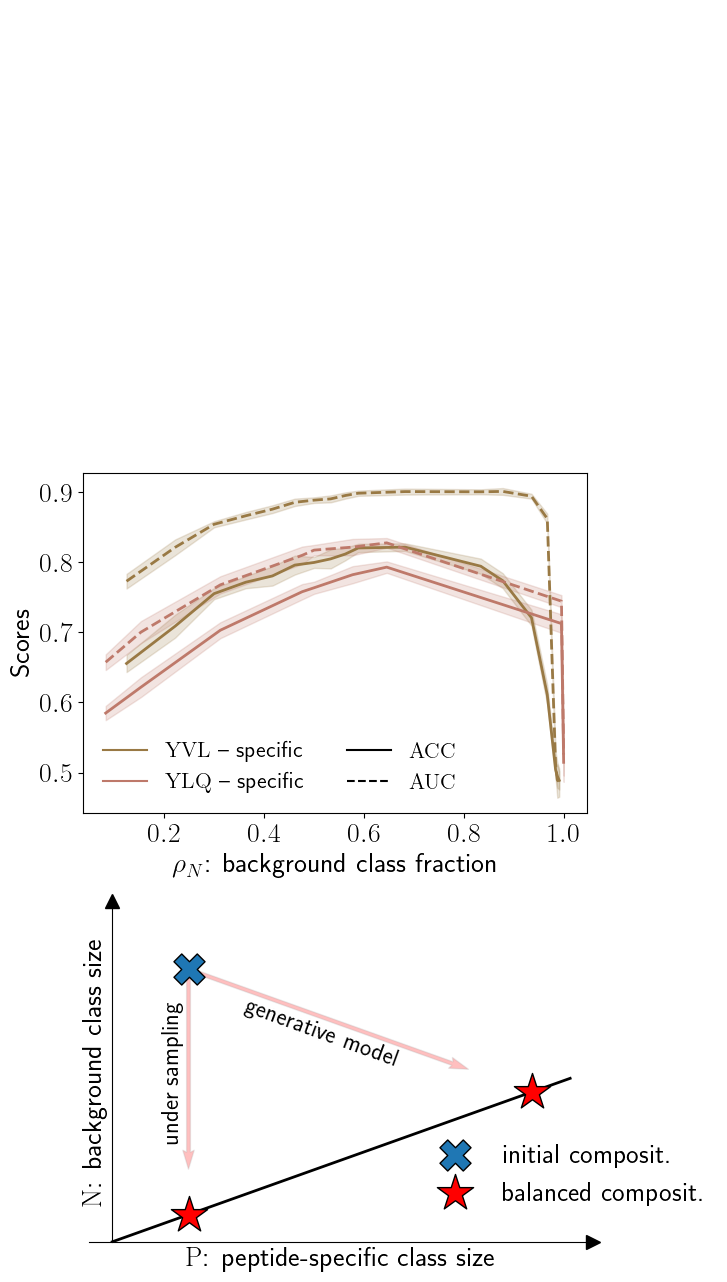

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('default')

S, B = 10,1

#rc = {"xtick.direction" : "inout", "ytick.direction" : "inout",
#      "xtick.major.size" : 5, "ytick.major.size" : 5,}
#plt.rcParams.update(plt.rcParamsDefault)
plt.rc('text', usetex=True)
plt.rcParams.update({'font.size':20})
plt.rc('text', usetex=True)

fig, ax = plt.subplots(ncols = 1,nrows = 3,gridspec_kw={'height_ratios': [1.1,1,1.]}, figsize = (6.5,16))
#fig, ax = plt.subplot_mosaic([["top","top"],["bottom left", "bottom right"]],gridspec_kw={'width_ratios': [1,1], 'height_ratios': [1.5,1]}, figsize = (15,13) )
                             
#ax.plot(x, y)
plt.subplots_adjust(hspace = 0.25)
ax[0].set_axis_off()

ax[2].spines['left'].set_position('zero')
ax[2].spines['right'].set_visible(False)
ax[2].spines['bottom'].set_position('zero')
ax[2].spines['top'].set_visible(False)
ax[2].xaxis.set_ticks_position('bottom')
ax[2].yaxis.set_ticks_position('left')
a = np.arange(S-3); ax[2].plot(a,a, color='black', lw = 2,alpha = 1,zorder=10)
#a = np.arange(B+0.17,S -0.15-3,step=0.001); ax[1].plot(a,a, color='black', lw = 2,alpha = 1,zorder=10)

ax[2].scatter(B, S,marker = 'X', edgecolors='black', s = 500, label ='initial composit.',zorder=25)
ax[2].scatter(B, B,marker = '*', edgecolors='black', color='red', alpha = 1, s = 750, label ='balanced composit.',zorder=25)
#ax[1].scatter(S, S,marker = '*', edgecolors='black', color='red', alpha = 1, s = 500,zorder=25)
ax[2].scatter(0.5*(B+S),0.5*(B+S),marker = '*', edgecolors='black', color='red', alpha = 1, s = 750,zorder=25)

ax[2].quiver([1,1],[S , S ], [0, 0.5*(B+S)], [-S+B-2,-0.5*(B+S)], scale_units='xy', angles='xy', color = 'red', alpha =0.25, 
           ls =['solid'],linewidth=1, edgecolor='darkgray', scale=1.5)

#ax[1].quiver([1,1,1],[S , S , S ], [0, 0.5*(B+S), S], [-S+B,-0.5*(B+S),0], scale_units='xy', angles='xy', color = 'red', alpha =0.25, 
#           ls =['solid'],linewidth=1, edgecolor='darkgray', scale=1.5)

#ax[1].text(B + 2,S+0.25, s = 'oversampling',fontsize=12.5)
ax[2].text(B-0.35,S-6.25, s = 'under sampling',fontsize=17.5, rotation='vertical')
ax[2].text(0.5*(B+S)-3.8,0.5*(B+S)+0.95, s = 'generative model',fontsize=17.5, rotation=-20)

# make arrows
ax[2].plot((1), (0), ls="", marker=">", ms=10, color="k",
        transform=ax[2].get_yaxis_transform(), clip_on=False)
ax[2].plot((0), (1), ls="", marker="^", ms=10, color="k",
        transform=ax[2].get_xaxis_transform(), clip_on=False)

ax[2].set_xticks([]); ax[2].set_yticks([])
ax[2].set_xlabel(r'$\mathrm{P}$: peptide-specific class size'); 
ax[2].set_ylabel(r'$\mathrm{N}$: background class size')
ax[2].legend(loc = [0.65,0.075], frameon=False,fontsize=19.5)
ax[2].set_ylim(0,S+2.5)


df = pd.read_csv('./AUCACC_performance_YVLDHLIVV_batchsize_512_P_7000.csv')
df.sort_values('Nsamples',inplace=True)

ax[1].plot(df.Nsamples/(df.Nsamples + df.Psamples), df['ACC-back'],lw=2., color = sns.color_palette("cubehelix",50)[24],
          label = r'ACC $\mathrm{YVL}$ -- specific')
ax[1].fill_between(df.Nsamples/(df.Nsamples + df.Psamples), 
                 df['ACC-back'] + df['stdACC-back']/np.sqrt(5), df['ACC-back'] - df['stdACC-back']/np.sqrt(5),
                   color= sns.color_palette("cubehelix",50)[24], alpha=0.2)

ax[1].plot(df.Nsamples/(df.Nsamples + df.Psamples), df['AUC-back'],lw=2., ls = '--', color = sns.color_palette("cubehelix",50)[24],
          label = r'AUC $\mathrm{YVL}$ -- specific')
ax[1].fill_between(df.Nsamples/(df.Nsamples + df.Psamples), 
                 df['AUC-back'] + df['std-back']/np.sqrt(5), df['AUC-back'] - df['std-back']/np.sqrt(5),
                   color= sns.color_palette("cubehelix",50)[24], alpha=0.2)

df = pd.read_csv('./AUCACC_performance_YLQPRTFLL_batchsize_128_P_550.csv')
df.sort_values('Nsamples',inplace=True)

ax[1].plot(df.Nsamples/(df.Nsamples + df.Psamples), df['ACC-back'],lw=2., color = sns.color_palette("cubehelix",50)[27],
          label = r'ACC $\mathrm{YLQ}$ -- specific')
ax[1].fill_between(df.Nsamples/(df.Nsamples + df.Psamples), 
                 df['ACC-back'] + df['stdACC-back']/np.sqrt(5), df['ACC-back'] - df['stdACC-back']/np.sqrt(5),
                   color= sns.color_palette("cubehelix",50)[27], alpha=0.2)

ax[1].plot(df.Nsamples/(df.Nsamples + df.Psamples), df['AUC-back'],lw=2., ls = '--', color = sns.color_palette("cubehelix",50)[27],
          label = r'AUC $\mathrm{YLQ}$ -- specific')
ax[1].fill_between(df.Nsamples/(df.Nsamples + df.Psamples), 
                 df['AUC-back'] + df['std-back']/np.sqrt(5), df['AUC-back'] - df['std-back']/np.sqrt(5),
                   color= sns.color_palette("cubehelix",50)[27], alpha=0.2)


handles = [Line2D([0], [0], label=r'$\mathrm{YVL}$ -- specific', marker='',
         color=sns.color_palette("cubehelix",50)[24], linestyle='-'),
          Line2D([0], [0], label=r'$\mathrm{YLQ}$ -- specific', marker='',
         color=sns.color_palette("cubehelix",50)[27], linestyle='-'),
           Line2D([0], [0], label=r'$\mathrm{ACC}$', marker='',
         color='black', linestyle='-'),
          Line2D([0], [0], label=r'$\mathrm{AUC}$', marker='',
         color='black', linestyle='--')
          ]



ax[1].set_xlabel(r'$\rho_N$: background class fraction')
ax[1].set_ylabel(r'Scores')
ax[1].legend(handles = handles, frameon=False,fontsize=16,ncol=2)

pos = ax[1].get_position()
new_pos = [pos.x0-0.01, pos.y0, pos.width, pos.height]
ax[1].set_position(new_pos)

plt.savefig('TCR_graphical_imbalance_full.pdf',bbox_inches = 'tight')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
X = np.random.normal(loc=-4,scale=1,size=(10000,2) )
Y = np.random.normal(loc=4,scale=1, size = (500,2))
from matplotlib.lines import Line2D

plt.rc('text', usetex=True)
plt.rcParams.update({'font.size':20})

S, B = 10,1

fig,ax = plt.subplots(figsize=(7.5,6), ncols=1, nrows=1)
plt.subplots_adjust(hspace=0.1)

ax.scatter(X[:,0],X[:,1],alpha=0.1,marker = '*', s = 150, color = '#edbc09')
ax.scatter(Y[:,0],Y[:,1],alpha = 0.1, marker ='s', s = 50, color = '#4a86e8ff')
start = [X.mean(axis=0)[0],Y.mean(axis=0)[0]]
end = [X.mean(axis=0)[1],Y.mean(axis=0)[1]]

ax.plot(start,end, 'ko', linestyle="--",alpha=0.5,markersize = 10, lw = 2)
#ax.scatter(0.5*(X.mean(axis=0)[0] + Y.mean(axis=0)[0]), 
#            0.5*(X.mean(axis=0)[1] + Y.mean(axis=0)[1]), s= 250 )
ax.plot([-2.5,2.5],[5.0,-4], lw = 2.5 , ls ='--', label = 'Optimal DB', color ='firebrick')
ax.plot([-1.5, 2.70],[6.5, -5], lw = 2.5,  ls ='--',alpha = 0.5, label =' Imbalanced DB', color ='lightcoral') 
ax.axis('off')
handles = [Line2D([0], [0], label='Majority', marker='*', markersize=13,
         color='#edbc09', linestyle=''),  Line2D([0], [0], label='Minority', marker='s', markersize=10,
         color='#4a86e8ff', linestyle='') ]
manual_leg = ax.legend(handles=handles, loc = [-0.05,0.8], frameon=False, ncol = 1, fontsize = 19)
ax.add_artist(manual_leg)
ax.legend(frameon=False, loc= 'lower right',fontsize = 19)
plt.savefig('./Imbalance_representation.pdf', bbox_inches = 'tight')

##### Fig. Peptide-specific model

In [12]:
epi_list_triplets = [
    r'$\mathrm{AMFWSVPTV}$' + '\n' + r'$\mathrm{VTEHDTLLY}$' + '\n' + r'$\mathrm{GLCTLVAML}$',
    r'$\mathrm{ELAGIGILTV}$' + '\n' + r'$\mathrm{GLCTLVAML}$' +'\n' + r'$\mathrm{LLWNGPMAV}$',
    r'$\mathrm{FLYNLLTRV}$' + '\n' + r'$\mathrm{VTEHDTLLY}$' +'\n' + r'$\mathrm{GLCTLVAML}$',
    r'$\mathrm{AMFWSVPTV}$' + '\n' + r'$\mathrm{ATDALMTGY}$' + '\n' + r'$\mathrm{YLQPRTFLL}$',
    r'$\mathrm{VTEHDTLLY}$' + '\n' + r'$\mathrm{GLCTLVAML}$' + '\n' + r'$\mathrm{LLWNGPMAV}$'
]
                  

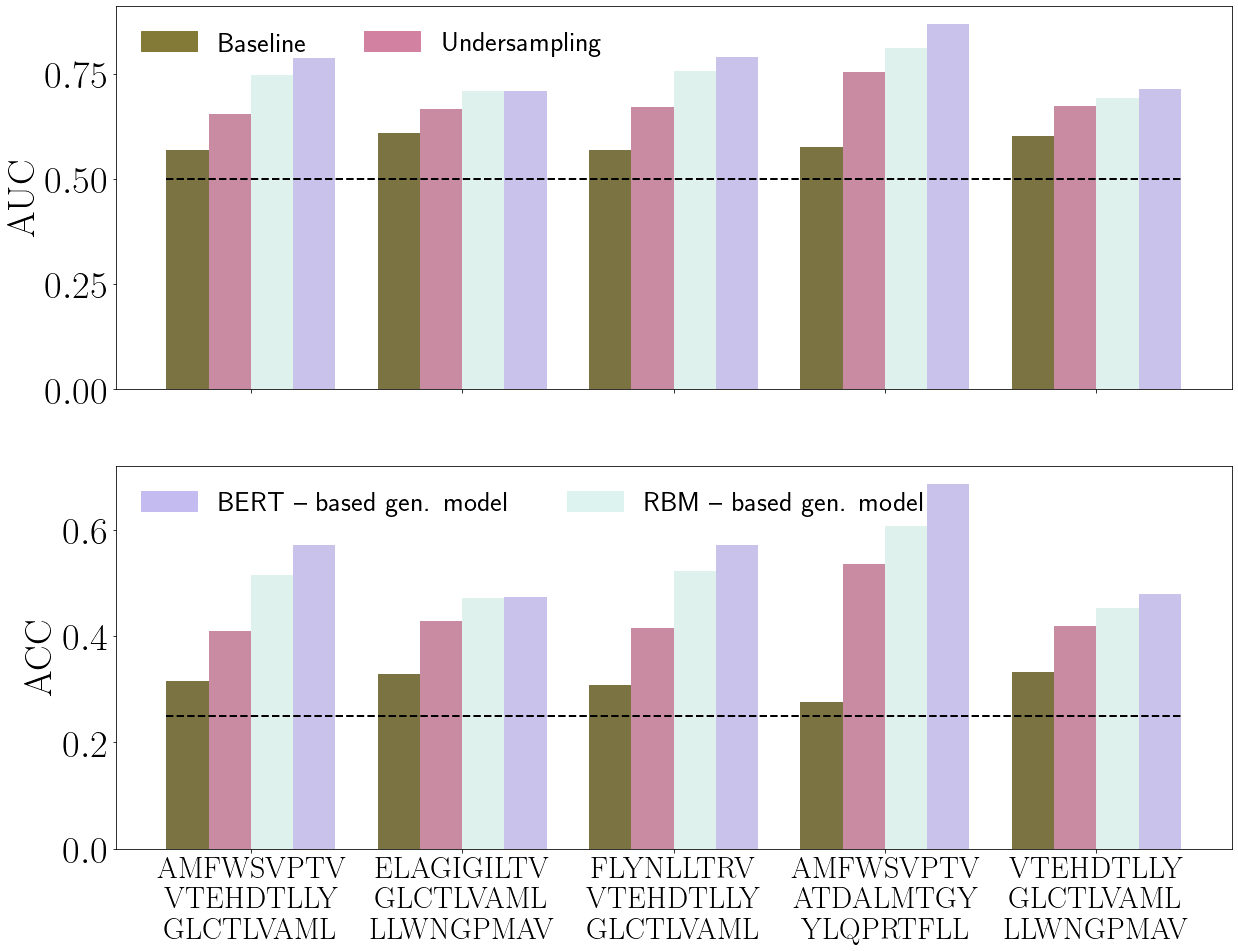

In [13]:
plt.rc('text', usetex=True)
plt.rcParams.update({'font.size':38.5})

colors=sns.color_palette("cubehelix",12)
sns.set_palette(colors)

dict_color_hue = {'Baseline': colors[5],'Null': colors[7], 'BERT': colors[9], 'RBM': colors[11] }

df = pd.read_csv('./Data/results_scores.csv')
fig,ax  = plt.subplots(figsize = (20,15.5), nrows=2 )
sns.barplot(data = df,x='triplets',y = 'ACC', hue = 'method', ax =ax[1], palette = dict_color_hue)
sns.barplot(data = df,x='triplets',y = 'AUC', hue = 'method', ax =ax[0], palette = dict_color_hue)

handles = [mpatches.Patch(color=colors[5], label='Baseline'),
           mpatches.Patch(color=colors[7], label='Undersampling'),
           mpatches.Patch(color=colors[9], label='BERT -- based gen. model'),
           mpatches.Patch(color=colors[11], label='RBM -- based gen. model')
           ]

#ax[0].set_ylim(0.0,0.90)
ax[0].legend(handles = handles[:2], loc = 'upper left', frameon=False, ncol=2, fontsize = 28)
ax[1].legend(handles = handles[2:], loc = 'upper left', frameon=False, ncol=2, fontsize = 28)

#ax[0].set_xticklabels(epi_list_triplets, rotation = 0, fontsize= 25  )
ax[0].set_xticklabels([]  )
ax[1].set_xticklabels(epi_list_triplets, rotation = 0, fontsize= 30  )
ax[0].set_xlabel(''); ax[1].set_xlabel('')
ax[0].set_ylabel(r'$\mathrm{AUC}$'); ax[1].set_ylabel(r'$\mathrm{ACC}$')
ax[0].hlines(0.50,-0.4,4.4,color = 'black',ls='--',lw =2)
ax[1].hlines(0.25,-0.4,4.4,color = 'black',ls='--',lw =2)

plt.savefig('./Peptidespec_results.pdf', bbox_inches = 'tight' )

##### Fig. Panspecific result presentation

In [6]:
epi_enlarged = []
with open('./Epi_enlarged_400.txt') as file:
    data = file.readlines()
    for line in data:
        if line.rstrip() not in epi_enlarged:
            epi_enlarged.append(line.rstrip() )
            
num_epitopes = []

with open('./Epitopes_list_num.txt') as file:
    data = file.readlines()
    for line in data:
        num_epitopes.append(line.rstrip().rsplit(' '))
        
dict_epi = {value[0]: int(value[1]) for value in num_epitopes}

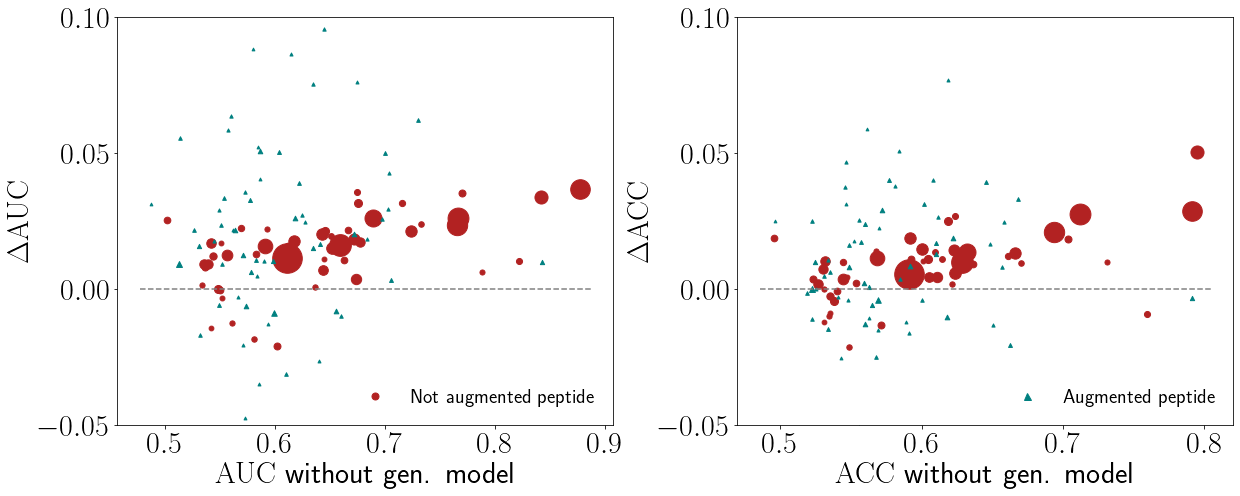

In [7]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches

cmap = matplotlib.cm.get_cmap('winter')

rgba = cmap(110)
df = pd.read_csv('./AUC_performance_multiepi_Datasets_control_P92778N92778_bal_wnegs_batch128.csv')
df_incl = pd.read_csv('./AUC_performance_multiepi_Datasets_control_P103631N103631_genbal_wnegs_batch128.csv')
markers, sizes, colors  = [], [], []
for peptide in df.columns:
    pept_is_enlarged = True if peptide in epi_enlarged else False
    markers.append( '^' if pept_is_enlarged else 'o' )
    sizes.append( dict_epi[peptide])
    colors.append( 'teal' if pept_is_enlarged else 'firebrick')
    
assert markers.count('^') == len(epi_enlarged)

#rc = {"xtick.direction" : "inout", "ytick.direction" : "inout",
#      "xtick.major.size" : 5, "ytick.major.size" : 5,}
#plt.rcParams.update(plt.rcParamsDefault)
plt.rc('text', usetex=True)
plt.rcParams.update({'font.size':30.})
plt.rc('text', usetex=True)

fig,ax = plt.subplots(figsize=(20,7.5), ncols = 2, nrows=1)
plt.subplots_adjust(wspace=0.25)

df = pd.read_csv('./AUC_performance_multiepi_Datasets_control_P92778N92778_bal_wnegs_batch128.csv')
df_incl = pd.read_csv('./AUC_performance_multiepi_Datasets_control_P103631N103631_genbal_wnegs_batch128.csv')

for i in range(len(colors)):
    ax[0].scatter(df.mean().iloc[i], df_incl.mean().iloc[i] - df.mean().iloc[i], c = colors[i], marker=markers[i], s = sizes[i]/20)
#ax[1].plot(np.arange(0.48,0.9,0.01),np.arange(0.48,0.9,0.01),c = 'grey',ls='--')
ax[0].hlines(0,min(df.mean() )-0.01, max( df.mean() )+0.01,color = 'grey',ls='--')
ax[0].locator_params(axis='x', nbins=6)
ax[0].set_ylim(-0.05, 0.10)
ax[0].set_ylabel(r'$\Delta \mathrm{AUC}$')
ax[0].set_xlabel(r'$\mathrm{AUC}$ without gen. model')

df = pd.read_csv('./ACC_performance_multiepi_Datasets_control_P92778N92778_bal_wnegs_batch128.csv')
df_incl = pd.read_csv('./ACC_performance_multiepi_Datasets_control_P103631N103631_genbal_wnegs_batch128.csv')

for i in range(len(colors)):
    ax[1].scatter(df.mean().iloc[i], df_incl.mean().iloc[i] - df.mean().iloc[i], c = colors[i], marker=markers[i], s = sizes[i]/20)
ax[1].hlines(0,min(df.mean() )-0.01, max( df.mean() )+0.01,color = 'grey',ls='--')
ax[1].set_ylim(-0.05, 0.10)
ax[1].set_ylabel(r'$\Delta \mathrm{ACC}$')
ax[1].set_xlabel(r'$\mathrm{ACC}$ without gen. model')

point_gen = Line2D([0], [0], label='Augmented peptide', marker='^', markersize=7, 
         color='teal', linestyle='')
point_nogen = Line2D([0], [0], label='Not augmented peptide', marker='o', markersize=7, 
         color='firebrick',linestyle='')
handles = [point_gen, point_nogen]
ax[1].legend(handles=[point_gen],frameon=False,fontsize=20, loc='lower right')
ax[0].legend(handles=[point_nogen],frameon=False,fontsize=20, loc='lower right')
#plt.savefig('./Pan_result_short.pdf',bbox_inches = 'tight')

##### Fig. Outsample multistructure LP proteins

(-101.24358147601144,
 101.69699769772858,
 -106.93752306733262,
 106.75489162575968)

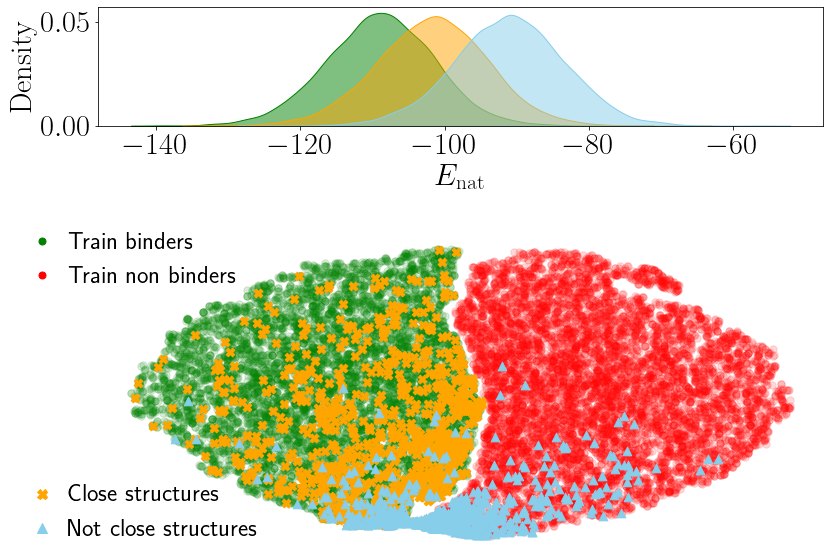

In [17]:
import seaborn as sns
plt.rcParams.update({'font.size':30.5})
plt.rc('text', usetex=True)

colors= ['green','red','skyblue']
fig, ax = plt.subplots(ncols=1,nrows = 2,gridspec_kw={'height_ratios':[0.75,2]}, figsize=(13,10) )
plt.subplots_adjust(hspace = 0.5)

list_ens = np.load('./LP_analysis/Listing_competing_energies.npy')
colors_en = ['green','orange','skyblue']
for k,energies in enumerate(list_ens):
    sns.kdeplot(energies ,color = colors_en[k],fill=True,cut=3,alpha = 0.5,ax = ax[0])
    
ax[0].set_xlabel(r'$E_\mathrm{nat}$')
ax[0].set_ylabel(r'$\mathrm{Density}$')

X = np.load('./LP_analysis/Embeddings_training.npy')
ax[1].scatter(X[:10000,0],X[:10000,1], s = 55,c = colors[0], alpha = 0.15 , label ='Train binders' )
ax[1].scatter(X[40000:50000,0],X[40000:50000,1], s = 55,c = colors[1], alpha = 0.15 , label ='Train non binders' )
point_train = Line2D([0], [0], label='Train binders', marker='o', markersize=7, color=colors[0], linestyle='')
point_trainno = Line2D([0], [0], label='Train non binders', marker='o', markersize=7, color=colors[1], linestyle='')
manual_leg = ax[1].legend(handles = [point_train, point_trainno], frameon = False, loc=[-0.125,0.8], ncol=1, fontsize = 24.5,handletextpad=0.1)
ax[1].add_artist(manual_leg)


X_out = np.load('./LP_analysis/Embeddings_outsamples_competdata.npy')
ax[1].scatter(X_out[:,0],X_out[:,1], marker='X',s = 75,c = 'orange', alpha = 1 , label ='Close structures' )

X_out = np.load('./LP_analysis/Embeddings_outsamples_noncompetdata.npy')
ax[1].scatter(X_out[:,0],X_out[:,1], marker='^', s = 75,c = 'skyblue', alpha = 1 , label ='Not close structures' )

point_close = Line2D([0], [0], label='Close structures', marker='X', markersize = 10, 
         color='orange', linestyle='')
point_noclose = Line2D([0], [0], label='Not close structures', marker='^', markersize = 10, 
         color='skyblue',linestyle='')
ax[1].legend(handles = [point_close,point_noclose], frameon = False, loc=[-0.125,0], ncol=1, fontsize = 24.5,handletextpad=0.1)

ax[1].axis('off')
#plt.savefig('./Outsamples_LP_multidimeric_structures.pdf',bbox_inches = 'tight')

#### Supplementary Figures

##### Fig. ELAGIGILTV out of samples

In [ ]:
plt.rc('text', usetex=True)
plt.rcParams.update({'font.size':20})

fig,axes = plt.subplots(figsize=(17,6.5),ncols=2)
plt.subplots_adjust(wspace = 0.05)
colors = ['orange','gold','tan']
list_outsamples = [r'$\mathrm{EAAGIGILTV}$',r'$\mathrm{VQELYSPIFLIV}$']
Z = np.load('./Data/Embeds_ELAGIGILTV_outsamples.npy')

for k,ax in enumerate(axes):
    ax.scatter(Z[250:500,0],Z[250:500,1], c = colors[1], alpha = 1, s = 120, label =r'$\mathrm{Background}$')
    ax.scatter(Z[:250,0],Z[:250,1], c = colors[0], alpha = 1, s = 120, label =r'$\mathrm{ELAGIGILTV}$')
    ax.scatter(Z[250*k + 500 :250*(k+1) + 500,0],Z[250*k + 500 :250*(k+1) + 500,1], 
               c = colors[2], alpha = 1, s = 120, label =list_outsamples[k])
    ax.set_ylim(-60,60)
    ax.legend(loc = [0,0.85],frameon=False)
    ax.set_axis_off()
    
plt.savefig('./TCR_CNN_outsamples_ELA.pdf', bbox_inches = 'tight')

##### Fig. Effect hyperparam tuning on pan-specific models

In [5]:
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')

In [6]:
list_values_size = [
93847,
95648,
98009,
100671,
106921,
110377,
113982,
117706]

list_maxsizes = [
200,
250,
300,
350,
450,
500,
550,
600]

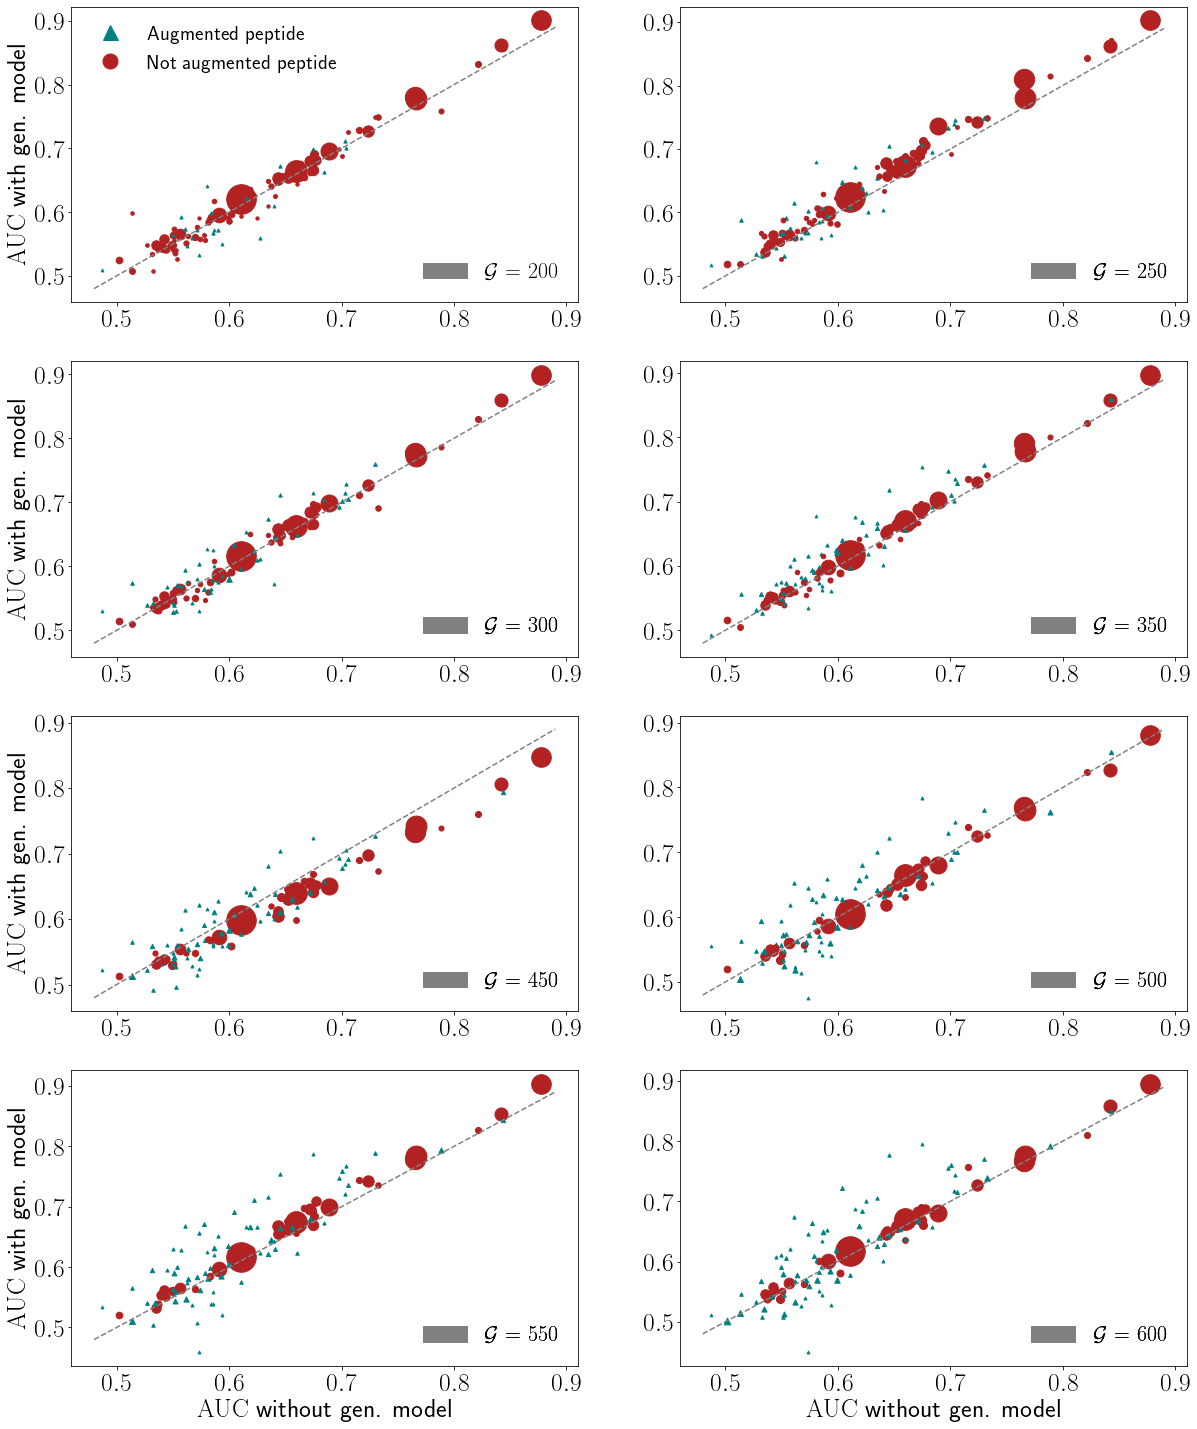

In [19]:
#plt.rcParams.update({    'text.usetex': True})
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')
plt.rcParams.update({'font.size':25.5})

fig,axes = plt.subplots(figsize=(20,25), ncols = 2, nrows = 4)
#plt.subplots_adjust(wspace=0.3)

num_epitopes = []

with open('./Epitopes_list_num.txt') as file:
    data = file.readlines()
    for line in data:
        num_epitopes.append(line.rstrip().rsplit(' '))
        
dict_epi = {value[0]: int(value[1]) for value in num_epitopes}

for i, ax in enumerate(axes.flatten() ):
    Sval = list_values_size[i]
    MAX_SIZE = list_maxsizes[i]
    
    df = pd.read_csv('./AUC_performance_multiepi_Datasets_control_P92778N92778_bal_wnegs_batch128.csv')
    df_incl = pd.read_csv(f'./Data/AUC_performance_multiepi_Datasets_control_P{Sval}N{Sval}_genbal_wnegs_batch128.csv')
    
    epi_enlarged = []
    with open(f'./Data/Epi_enlarged_{MAX_SIZE}.txt') as file:
        data = file.readlines()
        for line in data:
            if line.rstrip() not in epi_enlarged:
                epi_enlarged.append(line.rstrip() )
            

    markers, sizes, colors  = [], [], []
    for peptide in df.columns:
        pept_is_enlarged = True if peptide in epi_enlarged else False
        markers.append( '^' if pept_is_enlarged else 'o' )
        sizes.append( dict_epi[peptide])
        colors.append( 'teal' if pept_is_enlarged else 'firebrick')


    
    for i in range(len(colors)):
        ax.scatter(df.mean().iloc[i], df_incl.mean().iloc[i], c = colors[i], marker=markers[i], s = sizes[i]/20)
    ax.plot(np.arange(0.48,0.9,0.01),np.arange(0.48,0.9,0.01),c = 'grey',ls='--')
    handles = [mpatches.Patch(color='grey', label=r'$\mathcal{G}$' + r' = ${}$'.format(MAX_SIZE) ) ] 
    manual_leg = ax.legend(handles=handles, loc = 'lower right', frameon=False, fontsize = 22)
    ax.add_artist(manual_leg)

    #ax.set_xlabel(r'$\mathrm{AUC}$ without gen. model')
    #ax.set_ylabel(r'$\mathrm{AUC}$ with gen. model')
    
axes[0,0].set_ylabel(r'$\mathrm{AUC}$ with gen. model')
axes[1,0].set_ylabel(r'$\mathrm{AUC}$ with gen. model')
axes[2,0].set_ylabel(r'$\mathrm{AUC}$ with gen. model')
axes[3,0].set_ylabel(r'$\mathrm{AUC}$ with gen. model')
axes[3,0].set_xlabel(r'$\mathrm{AUC}$ without gen. model')
axes[3,1].set_xlabel(r'$\mathrm{AUC}$ without gen. model')

point_gen = Line2D([0], [0], label='Augmented peptide', marker='^', markersize=15, 
         color='teal', linestyle='')
point_nogen = Line2D([0], [0], label='Not augmented peptide', marker='o', markersize=15, 
         color='firebrick', linestyle='')
handles = [point_gen, point_nogen]
axes[0,0].legend(handles=handles,loc = 'upper left', frameon=False,fontsize=20.5)


plt.savefig('./Hyperparam_tuning_panspec_model.pdf',bbox_inches = 'tight' )

##### Fig. LP specific outsample

In [ ]:
from sklearn.metrics import roc_curve,auc
import sys
sys.path.append('./LP_analysis/')
import utils_prot
import seaborn as sns
plt.rcParams.update({'font.size':24.5})
plt.rc('text', usetex=True)

colors= ['green','red','skyblue']
#fig, ax = plt.subplots(ncols=1,nrows = 3,gridspec_kw={'height_ratios':[0.85,0.5,1]}, figsize=(7,11.5) )
fig,ax = plt.subplot_mosaic([['top','top'],['bl','br']],gridspec_kw={'height_ratios':[0.5,1], 'width_ratios': [ 0.95,1]} , figsize=(14,8) )
plt.subplots_adjust(hspace = 0.35)
plt.subplots_adjust(wspace = 0.05)



pbind_dict = {}
for k,step in enumerate([500,100,0]):
    pbind = []
    data = np.loadtxt(f'./LP_analysis/Full_MSA_step_{step}_beta_1_gamma_5.0_structA.txt').astype(np.int8)
    for sequence in data:
        pbind.append( utils_prot.pbind(0,sequence[:27], sequence[27:]) )
        
    pbind_dict[step] = pbind
    sns.kdeplot(np.array((pbind) ),color = colors[k],fill=True,cut=3,ax = ax['top'])
    
ax['top'].set_ylim(0,5)
ax['top'].set_ylabel(r'$\mathrm{Density}$')
ax['top'].set_xlabel(r'$\mathcal{P}_\mathrm{bind}$')

color_pink=sns.color_palette("cubehelix",5)[3:5]
color2=sns.color_palette("cubehelix",5)[2:3]
current_palette=color2+color_pink
sns.set_palette(current_palette)

fpr_keras, tpr_keras = np.load('./LP_analysis/ROC_test_in_LP_CNN_neg_isweak.npy') 
auc_keras = auc(fpr_keras, tpr_keras)
ax['bl'].plot(fpr_keras, tpr_keras, color = current_palette[0], lw = 3.5, label=r'Strong - Weak (AUC $= {:.2f}$)'.format(auc_keras))

fpr_keras, tpr_keras = np.load('./LP_analysis/ROC_test_posout_LP_CNN_neg_isweak.npy' )
auc_keras = auc(fpr_keras, tpr_keras)
ax['bl'].plot(fpr_keras, tpr_keras, color = current_palette[2],lw = 3.5, label=r'Strong - Non binder (AUC $= {:.2f}$)'.format(auc_keras))

fpr_keras, tpr_keras = np.load('./LP_analysis/ROC_test_negout_LP_CNN_neg_isweak.npy' )
auc_keras = auc(fpr_keras, tpr_keras)
ax['bl'].plot([0,1],[0,1],'k--')
ax['bl'].plot(fpr_keras, tpr_keras, color = current_palette[1],lw = 3.5, label=r'Weak - Non binder (AUC $= {:.2f}$)'.format(auc_keras))

ax['bl'].set_xlabel(r'$\mathrm{FPR}$')
ax['bl'].set_ylabel(r'$\mathrm{TPR}$')
ax['bl'].legend(frameon = False, fontsize=14)


T = np.load('./LP_analysis/Embeddings_LP_CNN_neg_isweak_featlayer.npy')
T[:,0] *= -1
ax['br'].scatter(T[:500,0],T[:500,1], s = 50,c = colors[0], alpha = 1 , label ='Strong' )
ax['br'].scatter(T[500:1000,0],T[500:1000,1],s = 50, c = colors[1], alpha = 1, label ='Weak' )
ax['br'].scatter(T[1000:,0],T[1000:,1], s = 50,c = colors[2], alpha = 1, label = 'Non binder' )
ax['br'].legend(frameon = False, loc=[0.42,1.57], ncol=2, fontsize = 14)
ax['br'].axis('off')
#plt.text(-67.5,-45,s = r'AUC P-O $=0.96$')
#plt.text(-67.5,-52.5,s = r'AUC N-O $=0.41$')

plt.savefig('./Fig_outsamples_LP_2.pdf',bbox_inches = 'tight')